# Travel Agency - Delay Prediction

## Load packages and data

Change your path here:

In [7]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import datetime as dt
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta

from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer

Load the four datasets provided.

In [8]:
# write the paths for the online csvs
path_1 = 'https://www.dropbox.com/s/zfd2jv6rpxhzs92/airlines.csv?dl=1'
path_2 = 'https://www.dropbox.com/s/3z5f81ek9x0z5xq/airports.csv?dl=1'
path_3 = 'https://www.dropbox.com/s/3px6i27kizxjrwg/historic_data.csv?dl=1'
path_4 = 'https://www.dropbox.com/s/i1t83un3phi3w36/future_data.csv?dl=1'

In [ ]:
# read in the csvs
df_airlines = pd.read_csv(path_1, header=0)
df_airports = pd.read_csv(path_2, index_col=None, header=0)
df_hdata = pd.read_csv(path_3, index_col=None, header=0)
df_fdata = pd.read_csv(path_4, index_col=None, header=0)

In [ ]:
# look at airlines df
# df_airlines.head()
len(df_airlines)

In [ ]:
# look at airport df
# df_airports.head()
len(df_airports)

In [6]:
# look at historical df
# df_hdata.head()
len(df_hdata)

2458628

In [7]:
# look at future df
# df_fdata.head()
len(df_fdata)

469968

Based on the observation of dataframes:
1. In the model, the only variables we can use to predict are the ones in "future_data": scheduled_departure, scheduled_arrival, airline, flight_number, Tail_number, origin_airport, destination_airport, distance.

2. Airline dataset: no added value information --> not used

3. Airports dataset: latitude and longitude of airport, country, city, state of the airport --> should merge into both training and predicting datasets

4. Historic data - to predict: 1. arrival delay (main one and need to be constructed); 2. cancellation dummy; 3. cancellation reasons; 4. delay reasons

5. Additionally, we can also see the most important factor for delay or cancellation.

## Initial exploration

<AxesSubplot:>

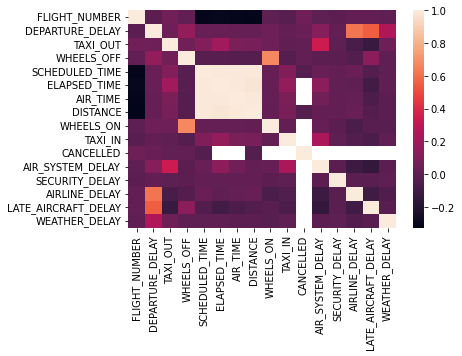

In [8]:
# correlation heat map of the historical df variables
corr = df_hdata.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Data Preprocessing

What variables can be used in prediction?
1. scheduled departure
2. scheduled arrival
3. airline
4. flight number
5. tail number
6. origin airport
7. destination airport
8. distance

Available after merging:
1. origin country/city/state/latitude/longitude
2. destination country/city/state/latitude/longitude

Available after construction: scheduled duration

Note: datetime variables cannot be used, extract days and hours, maybe weekend dummy.

### Merge Airports dataset

Visualise the airports in the dataset.

Rename airports columns: OR is short for "origin"; DES is short for "DESTINATION"

In [9]:
df_air_or = df_airports.rename(columns={'IATA_CODE':'ORIGIN_AIRPORT', 'CITY': 'OR_CITY', 'STATE': 'OR_STATE', 'COUNTRY': 'OR_COUNTRY', 'LATITUDE': 'OR_LATITUDE', 'LONGITUDE': 'OR_LONGITUDE'}, index={'ONE': 'Row_1'})
df_air_des = df_airports.rename(columns={'IATA_CODE':'DESTINATION_AIRPORT', 'CITY': 'DES_CITY', 'STATE': 'DES_STATE', 'COUNTRY': 'DES_COUNTRY', 'LATITUDE': 'DES_LATITUDE', 'LONGITUDE': 'DES_LONGITUDE'}, index={'ONE': 'Row_1'})

Merge historic data with airport dataset

In [10]:
df_final1 = df_hdata.merge(df_air_or, how='left', on='ORIGIN_AIRPORT', left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)
df_final2 = df_final1.merge(df_air_des, how='left', on='DESTINATION_AIRPORT', left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

In [11]:
df_final2.head()

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,...,OR_STATE,OR_COUNTRY,OR_LATITUDE,OR_LONGITUDE,AIRPORT_y,DES_CITY,DES_STATE,DES_COUNTRY,DES_LATITUDE,DES_LONGITUDE
0,2019-03-01 00:01:00,00:02:00,01:37:00,01:20:00,UA,1238,N812UA,DEN,BIL,1.0,...,CO,USA,39.85841,-104.66700,Billings Logan International Airport,Billings,MT,USA,45.80766,-108.54286
1,2019-03-01 00:01:00,00:29:00,01:33:00,01:52:00,EV,6134,N14171,ORD,BNA,28.0,...,IL,USA,41.97960,-87.90446,Nashville International Airport,Nashville,TN,USA,36.12448,-86.67818
2,2019-03-01 00:01:00,NaN,01:53:00,NaN,EV,4682,N15910,ORD,BHM,NaN,...,IL,USA,41.97960,-87.90446,Birmingham-Shuttlesworth International Airport,Birmingham,AL,USA,33.56294,-86.75355
3,2019-03-01 00:02:00,23:59:00,03:04:00,02:56:00,UA,1550,N822UA,ORD,BTV,-3.0,...,IL,USA,41.97960,-87.90446,Burlington International Airport,Burlington,VT,USA,44.47300,-73.15031
4,2019-03-01 00:02:00,00:36:00,03:22:00,03:30:00,UA,1502,N33262,ORD,BOS,34.0,...,IL,USA,41.97960,-87.90446,Gen. Edward Lawrence Logan International Airport,Boston,MA,USA,42.36435,-71.00518


In [ ]:
df_final = df_final2.rename(columns={'AIRPORT_x':'OR_AIRPORT_NAME', 'AIRPORT_y': 'DES_AIRPORT_NAME'})
df_final.head()

### Datetime

In [ ]:
# creating a new df to work with
df_datetime = pd.DataFrame()

In [ ]:
df_datetime['scheduled_departure'] = pd.to_datetime(df_final['SCHEDULED_DEPARTURE'], format='%Y-%m-%d %H:%M:%S')
df_datetime['scheduled_arrival'] = pd.to_datetime(df_final['SCHEDULED_ARRIVAL'], format='%H:%M:%S')

In [ ]:
df_datetime['time_ar'] = df_final['SCHEDULED_ARRIVAL'].dt.time
df_datetime['time_de'] = df_final['SCHEDULED_DEPARTURE'].dt.time
df_datetime['year_de'] = df_final['SCHEDULED_DEPARTURE'].dt.year
df_datetime['month_de'] = df_final['SCHEDULED_DEPARTURE'].dt.month
df_datetime['day_de'] = df_final['SCHEDULED_DEPARTURE'].dt.day
df_datetime['weekday_de'] = df_final['SCHEDULED_DEPARTURE'].dt.weekday
df_datetime['hour_de'] = df_final['SCHEDULED_DEPARTURE'].dt.hour

In [ ]:
df_datetime.head()

In [ ]:
# empty lists to append to
date_ar = []
flight_duration = []

In [ ]:
# adjusting for flights that last over 24 hours
for i in range(len(df_datetime)):
    if datetime.combine(date.today(), time_ar[i]) < datetime.combine(date.today(), time_de[i]):
        fd = datetime.combine(date.today(), time_ar[i]) - datetime.combine(date.today(), time_de[i])
        date_ar.append(df_datetime.day_de[i] + 1)
        flight_duration.append(fd)
#         print(df_datetime.day_de[i] + 1)
    elif datetime.combine(date.today(), time_ar[i]) > datetime.combine(date.today(), time_de[i]):
        fd = datetime.combine(date.today(), time_ar[i]) - datetime.combine(date.today(), time_de[i])
        date_ar.append(df_datetime.day_de[i])
        flight_duration.append(fd)
#         print(df_datetime.day_de[i])
    elif datetime.combine(date.today(), time_ar[i]) == datetime.combine(date.today(), time_de[i]):
        date_ar.append('24_hours')
        flight_duration.append('24_hours')

In [ ]:
len(date_ar)

In [ ]:
len(flight_duration)

In [ ]:
df_datetime['date_ar'] = date_ar

All observations come from the same year, then not useful in the model.

In [ ]:
df_datetime.date_ar.value_counts()

Month varies from 3 to 7, avoid the summer or winter vacation already, then maybe not that useful.

In [ ]:
df_datetime.day_de.value_counts()

### Delayed Variable -- arrival delay (dummy, continous, ordinal, different delay threshold...)

In [ ]:
max_departure = max(df_final['DEPARTURE_DELAY'])

In [ ]:
print(max_departure)

In [ ]:
max_schedule = max(df_final['SCHEDULED_TIME'])

The maximum flying time is 11.75 hours.

In [ ]:
print(max_schedule)

The departure delay can be over 24 hours (a day and 7.3 hours). Then the calculation of arrival delay comes down to get the exact date of arrival:

1. to get the date and time of expected arrival time --> scheduled departure + expected flying time (scheduled time) 
2. to get the date and time of actual arrival time --> acutal departure time + ELAPSED time
3. calculate the arrival delay

In [ ]:
fmt="%Y/%m/%d %H:%M:%S"
fmt2="%H:%M:%S"

To build dates on each flight stage

1) actual departure time

In [ ]:
act_dept_time = pd.to_datetime(df_final['SCHEDULED_DEPARTURE'], format = fmt) + pd.to_timedelta(df_final['DEPARTURE_DELAY'], 'm')

2) arrival_time: DEP_date_time + tax_out (min) +airtime (min) + tax_in (min)

In [ ]:
arrival_time = act_dept_time + pd.to_timedelta(df_final['TAXI_IN'],'m') + pd.to_timedelta(df_final['TAXI_OUT'], 'm') + pd.to_timedelta(df_final['AIR_TIME'], 'm')

3) compute the date of schedule arrival: SCHEDULED_DEPARTURE+SCHEDULED_TIME (min)


In [ ]:
sched_arrival = pd.to_datetime(df_final['SCHEDULED_DEPARTURE'], format = fmt) + pd.to_timedelta(df_final['SCHEDULED_TIME'], 'm')

4) compute arrival delay: schedule arrival - ARR_DATE_TIME

In [ ]:
arrival_delay =(arrival_time - sched_arrival).astype('timedelta64[m]')

To compare with the initial delay version


In [ ]:
arrival_delay_v2 = (pd.to_datetime(arrival_time, format=fmt2) - pd.to_datetime(sched_arrival, format = fmt2)).astype('timedelta64[m]')

In [ ]:
act_dept_time[0]

Approach as classification problem: "A flight os counted as "on time" if it operated less than 15 minutes later than the scheduled time shown in the carriers' Computerozed Researvation Systems (CRS)"

In [ ]:
# approach as classification problem 
df_final['ARRIVAL_DELAY'] = (df_final['ARRIVAL_DELAY_v1'] > 15).astype(int)

### Additional Constructed Variable: (expected/scheduled) speed

In [ ]:
df_final['SPEED'] = df_final['DISTANCE']/df_final['SCHEDULED_TIME']

### Drop Irrelavent Variables

In [ ]:
df_final.dtypes

Drop the variables not in the future dataset:

In [ ]:
df_final = df_final.drop(['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL','DEPARTURE_TIME','ARRIVAL_TIME','TAXI_OUT','WHEELS_OFF','ELAPSED_TIME','AIR_TIME','WHEELS_ON','OR_COUNTRY','DES_COUNTRY','TAXI_IN','TIME_AR','TIME_DE','YEAR_DE','MONTH_DE','DAY_DE','WEEKDAY_DE','DEP_DATE_TIME','ARR_DATE_TIME','SCH_ARR_DATE_TIME', 'ARRIVAL_DELAY_v2'], axis = 1)
df_final.head()

### Missing values

In [ ]:
df_final.dtypes

Observe if the final dataset has missing values.

count total NaN at each column in a DataFrame

In [ ]:
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      df_final.isnull().sum())

We observe that:
1. there are several missing values in Tail_number --> will try to model with and without the variable
2. missing values for departure delay means no delay --> recode as 0
3. cancellation_reason missing means not canceled --> recode as 0
4. delayed_reason missing means not delayed for it --> recode as 0
5. missing values for latitude and longitude --> drop for now, but we can impute by looking up the latitude and longitude of the city

In [ ]:
# Replace missing values
df_final['DEPARTURE_DELAY'] = df_final['DEPARTURE_DELAY'].fillna(0)
df_final['CANCELLATION_REASON'] = df_final['CANCELLATION_REASON'].fillna(0)
df_final['AIR_SYSTEM_DELAY'] = df_final['AIR_SYSTEM_DELAY'].fillna(0)
df_final['SECURITY_DELAY'] = df_final['SECURITY_DELAY'].fillna(0)
df_final['AIRLINE_DELAY'] = df_final['AIRLINE_DELAY'].fillna(0)
df_final['LATE_AIRCRAFT_DELAY'] = df_final['LATE_AIRCRAFT_DELAY'].fillna(0)
df_final['WEATHER_DELAY'] = df_final['WEATHER_DELAY'].fillna(0)
df_final['ARRIVAL_DELAY_v1'] = df_final['ARRIVAL_DELAY_v1'].fillna(0)

In [ ]:
# Count total NaN at each column in a DataFrame
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      df_final.isnull().sum())

In [ ]:
df_final = df_final.dropna(axis=0, how='any')
df_final.head()

In [ ]:
#df_final.to_csv(index=False)